# Data Preparation

## Why do this step?

- The data we scraped from the UFC website is raw data. Every row contains information about a fight that took place i.e. details like how many strikes were thrown in that fight and who won the fight.
- To prepare the data for prediction, every row can contain only an accurate representation of what each fighter has done in fights up until that fight! No data that was recorded during the fight can be present in that row.
- Our Target variable is Winner. The task has to be to predict the winner from the data available of each fighter up until the fight

## Looking at the data

In [47]:
import pandas as pd
import numpy as np
import math
import os
print(os.getcwd())

df = pd.read_csv('../src/data/raw_total_fight_data.csv', sep=';')
fighter_details = pd.read_csv('../src/data/raw_fighter_details.csv', index_col='fighter_name')


C:\Users\lah25\repos\UFC-Predictions\notebooks


In [173]:
TEST_fighter_details = pd.read_csv('../src/data/raw_fighter_details.csv', index_col='fighter_name')
mask = TEST_fighter_details['Height'].apply(lambda x: isinstance(x, str) and len(x.split("'")) == 2)
TEST_fighter_details[mask]

,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
fighter_name,,,,,,,,,,,,,
David Abbott,"6' 0""",265 lbs.,NaN,Switch,"Apr 26, 1965",1.35,30%,3.55,38%,1.07,33%,66%,0.0
Nariman Abbasov,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994",3.00,20%,5.67,46%,0.00,0%,66%,0.0
Shamil Abdurakhimov,"6' 3""",235 lbs.,"76""",Orthodox,"Sep 02, 1981",2.41,44%,3.02,55%,1.01,23%,45%,0.1
Hamdy Abdelwahab,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993",3.40,51%,3.87,51%,2.00,80%,100%,0.0
Mansur Abdul-Malik,"6' 2""",185 lbs.,"79""",Orthodox,"Oct 07, 1997",5.29,54%,3.84,49%,0.75,33%,82%,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cat Zingano,"5' 6""",145 lbs.,"68""",Southpaw,"Jul 01, 1982",2.57,61%,1.63,47%,2.77,65%,42%,0.8
Igor Zinoviev,"6' 1""",199 lbs.,NaN,Orthodox,NaN,0.00,0%,0.00,0%,0.00,0%,0%,0.0
George Zuniga,"5' 9""",185 lbs.,NaN,NaN,NaN,7.64,38%,5.45,37%,0.00,0%,100%,0.0


In [244]:
TEST_df = pd.read_csv('../src/data/raw_total_fight_data.csv', sep=';')
TEST_df['last_round_time']#.isnull().sum()
TEST_df['last_round_time'] = TEST_df['last_round_time'].apply(lambda X: int(X.split(':')[0])*60 + int(X.split(':')[1]))
TEST_df['total_time_fought(seconds)'] = TEST_df.apply(get_total_time, axis=1)
TEST_df['total_time_fought(seconds)'].isnull().sum()
mask = (TEST_df['R_fighter'].str.count(' ') == 0) | (TEST_df['B_fighter'].str.count(' ') == 0) | (TEST_df['Winner'].str.count(' ') == 0)

def winner_is_valid(row):
    winner = row['Winner']
    return pd.isna(winner) or winner in [row['R_fighter'], row['B_fighter']]

# Step 1: Filter just the relevant rows
mask = (TEST_df['R_fighter'].str.count(' ') == 0) | (TEST_df['B_fighter'].str.count(' ') == 0)
single_name_fights = TEST_df[mask].loc[:, ['R_fighter', 'B_fighter', 'Winner']]

# Step 2: Apply the function and add result as a new column
single_name_fights['matched_winner'] = single_name_fights.apply(winner_is_valid, axis=1)

# Done! You can now inspect this column
single_name_fights

# Filter mismatches
mismatches = single_name_fights[single_name_fights['matched_winner'] == False]

# Show exact differences for inspection
for idx, row in mismatches.iterrows():
    winner = repr(row['Winner'])
    red = repr(row['R_fighter'])
    blue = repr(row['B_fighter'])
    print(f"\nIndex: {idx}")
    print(f"  Winner: {winner}")
    print(f"  R_fighter: {red}")
    print(f"  B_fighter: {blue}")


Index: 565
  Winner: ' Maheshate'
  R_fighter: 'Gabriel Benitez'
  B_fighter: 'Maheshate'

Index: 1397
  Winner: ' Alatengheili'
  R_fighter: 'Chad Anheliger'
  B_fighter: 'Alatengheili'

Index: 2907
  Winner: ' Mizuki'
  R_fighter: 'Wu Yanan'
  B_fighter: 'Mizuki'


In [48]:
df.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Mateusz Gamrot,Ludovit Klein,0,0,65 of 110,24 of 74,59%,32%,142 of 224,85 of 145,...,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"May 31, 2025","Las Vegas, Nevada, USA",Lightweight Bout,Mateusz Gamrot
1,Zachary Reese,Dusko Todorovic,0,0,50 of 108,35 of 65,46%,53%,73 of 135,73 of 109,...,7 of 9,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,"May 31, 2025","Las Vegas, Nevada, USA",Middleweight Bout,Zachary Reese
2,Rayanne dos Santos,Alice Ardelean,0,0,78 of 225,154 of 352,34%,43%,79 of 227,159 of 359,...,0 of 1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Chris Tognoni,"May 31, 2025","Las Vegas, Nevada, USA",Women's Strawweight Bout,Alice Ardelean
3,Dustin Jacoby,Bruno Lopes,1,0,17 of 29,3 of 9,58%,33%,17 of 30,5 of 12,...,0 of 0,KO/TKO,1,1:50,3 Rnd (5-5-5),Mike Beltran,"May 31, 2025","Las Vegas, Nevada, USA",Light Heavyweight Bout,Dustin Jacoby
4,Ketlen Vieira,Macy Chiasson,0,0,28 of 64,22 of 43,43%,51%,106 of 174,52 of 77,...,0 of 0,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Mark Smith,"May 31, 2025","Las Vegas, Nevada, USA",Women's Featherweight Bout,Ketlen Vieira


In [49]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,8149,8150,8151,8152,8153,8154,8155,8156,8157,8158
R_fighter,Mateusz Gamrot,Zachary Reese,Rayanne dos Santos,Dustin Jacoby,Ketlen Vieira,Kurt Holobaugh,Jafel Filho,Billy Ray Goff,Bolaji Oki,Julian Erosa,...,Patrick Smith,Jason DeLucia,Johnny Rhodes,Remco Pardoel,Remco Pardoel,Orlando Wiet,Frank Hamaker,Patrick Smith,Scott Morris,Johnny Rhodes
B_fighter,Ludovit Klein,Dusko Todorovic,Alice Ardelean,Bruno Lopes,Macy Chiasson,Jordan Leavitt,Allan Nascimento,Ramiz Brahimaj,Michael Aswell,Melquizael Costa,...,Johnny Rhodes,Scott Baker,Fred Ettish,Alberta Cerra Leon,Orlando Wiet,Robert Lucarelli,Thaddeus Luster,Ray Wizard,Sean Daugherty,David Levicki
R_KD,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
B_KD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R_SIG_STR.,65 of 110,50 of 108,78 of 225,17 of 29,28 of 64,0 of 1,14 of 30,1 of 3,136 of 303,69 of 173,...,5 of 12,3 of 5,13 of 29,4 of 6,7 of 7,8 of 12,2 of 3,1 of 1,1 of 1,11 of 17
B_SIG_STR.,24 of 74,35 of 65,154 of 352,3 of 9,22 of 43,1 of 1,12 of 24,1 of 1,118 of 309,102 of 204,...,4 of 9,0 of 2,4 of 7,1 of 3,1 of 2,2 of 6,0 of 0,1 of 1,0 of 4,4 of 5
R_SIG_STR_pct,59%,46%,34%,58%,43%,0%,46%,33%,44%,39%,...,41%,60%,44%,66%,100%,66%,66%,100%,100%,64%
B_SIG_STR_pct,32%,53%,43%,33%,51%,100%,50%,100%,38%,50%,...,44%,0%,57%,33%,50%,33%,---,100%,0%,80%
R_TOTAL_STR.,142 of 224,73 of 135,79 of 227,17 of 30,106 of 174,7 of 9,40 of 63,2 of 4,136 of 303,85 of 202,...,5 of 12,20 of 25,21 of 38,20 of 22,7 of 7,11 of 15,14 of 15,1 of 1,2 of 2,74 of 86
B_TOTAL_STR.,85 of 145,73 of 109,159 of 359,5 of 12,52 of 77,2 of 3,30 of 58,9 of 10,118 of 309,128 of 236,...,4 of 9,14 of 23,7 of 11,9 of 11,5 of 7,2 of 6,0 of 0,2 of 2,1 of 5,95 of 102


In [50]:
df.describe()
fighter_details.dtypes


Height      object
Weight      object
Reach       object
Stance      object
DOB         object
SLpM       float64
Str_Acc     object
SApM       float64
Str_Def     object
TD_Avg     float64
TD_Acc      object
TD_Def      object
Sub_Avg    float64
dtype: object

In [51]:
df.dtypes

R_fighter          object
B_fighter          object
R_KD                int64
B_KD                int64
R_SIG_STR.         object
B_SIG_STR.         object
R_SIG_STR_pct      object
B_SIG_STR_pct      object
R_TOTAL_STR.       object
B_TOTAL_STR.       object
R_TD               object
B_TD               object
R_TD_pct           object
B_TD_pct           object
R_SUB_ATT           int64
B_SUB_ATT           int64
R_REV               int64
B_REV               int64
R_CTRL             object
B_CTRL             object
R_HEAD             object
B_HEAD             object
R_BODY             object
B_BODY             object
R_LEG              object
B_LEG              object
R_DISTANCE         object
B_DISTANCE         object
R_CLINCH           object
B_CLINCH           object
R_GROUND           object
B_GROUND           object
win_by             object
last_round          int64
last_round_time    object
Format             object
Referee            object
date               object
location    

In [52]:
df.columns

Index(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR.', 'B_SIG_STR.',
       'R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TOTAL_STR.', 'B_TOTAL_STR.',
       'R_TD', 'B_TD', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL', 'R_HEAD', 'B_HEAD', 'R_BODY',
       'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH',
       'B_CLINCH', 'R_GROUND', 'B_GROUND', 'win_by', 'last_round',
       'last_round_time', 'Format', 'Referee', 'date', 'location',
       'Fight_type', 'Winner'],
      dtype='object')

### Column definitions:

- `R_` and `B_` prefix signifies red and blue corner fighter stats respectively
- `KD` is number of knockdowns
- `SIG_STR` is no. of significant strikes 'landed of attempted'
- `SIG_STR_pct` is significant strikes percentage
- `TOTAL_STR` is total strikes 'landed of attempted'
- `TD` is no. of takedowns
- `TD_pct` is takedown percentages
- `SUB_ATT` is no. of submission attempts
- `PASS` is no. times the guard was passed?
- `REV` is the no. of reversals
- `CTRL` is the time spent with ground control
- `HEAD` is no. of significant strinks to the head 'landed of attempted'
- `BODY` is no. of significant strikes to the body 'landed of attempted'
- `CLINCH` is no. of significant strikes in the clinch 'landed of attempted'
- `GROUND` is no. of significant strikes on the ground 'landed of attempted'
- `win_by` is method of win
- `last_round` is last round of the fight (ex. if it was a KO in 1st, then this will be 1)
- `last_round_time` is when the fight ended in the last round
- `Format` is the format of the fight (3 rounds, 5 rounds etc.)
- `Referee` is the name of the Ref
- `date` is the date of the fight
- `location` is the location in which the event took place
- `Fight_type` is which weight class and whether it's a title bout or not
- `Winner` is the winner of the fight

#### Per fighter career wide stats
- `SLpM` - Significant Strikes Landed per Minute
- `Str_Acc.` - Significant Striking Accuracy
- `SApM` - Significant Strikes Absorbed per Minute
- `Str_Def` - Significant Strike Defence (the % of opponents strikes that did not land)
- `TD_Avg` - Average Takedowns Landed per 15 minutes
- `TD_Acc` - Takedown Accuracy
- `TD_Def` - Takedown Defense (the % of opponents TD attempts that did not land)
- `Sub_Avg` - Average Submissions Attempted per 15 minutes 

## Todo:

- Separate `landed of attempted` to separate columns

- Convert `Fight_type` into two separate columns, `weight_class` and `Title_fight` (True or False)

- Convert `last_round_time` to `total_time_fought` by using `last_round` and `Format`

- Convert `CTRL` to `time_in_CTRL`

- Convert percentages to fractions

- Since the data is a description of each fight, we have to convert it into a format that shows the compilation data of each fighter up until that fight. This means every row will look a lot different than it looks now.

- Create `current_win_streak`, `current_lose_streak`, `longest_win_streak`, `wins`, `losses`, `draw`

- Create fighter `height`, `reach`, `weight`, `age`

In [53]:
 ''' 
 We are dropping these stats to prevent data leakage affecting our results for testing the model. Since these stats are up to date they include information
from what will be the testing data. There is potential to use them for aiding the model down the line since they are only useful for up to date fights but we'll see.
'''

SyntaxError: unterminated string literal (detected at line 2) (2113752071.py, line 2)

In [ ]:
fighter_details.drop(
    columns=["SLpM",
            "Str_Acc",
            "SApM",
            "Str_Def",
            "TD_Avg",
            "TD_Acc",
            "TD_Def",
            "Sub_Avg",
        ], inplace=True)

### Splitting landed of attempted to different columns

In [54]:
columns = ['R_SIG_STR.', 'B_SIG_STR.', 'R_TOTAL_STR.', 'B_TOTAL_STR.',
       'R_TD', 'B_TD', 'R_HEAD', 'B_HEAD', 'R_BODY','B_BODY', 'R_LEG', 'B_LEG', 
        'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH','B_CLINCH', 'R_GROUND', 'B_GROUND']

for column in columns:
    print(f"{column} data type is: {df[column].dtype}")
df.columns


R_SIG_STR. data type is: object
B_SIG_STR. data type is: object
R_TOTAL_STR. data type is: object
B_TOTAL_STR. data type is: object
R_TD data type is: object
B_TD data type is: object
R_HEAD data type is: object
B_HEAD data type is: object
R_BODY data type is: object
B_BODY data type is: object
R_LEG data type is: object
B_LEG data type is: object
R_DISTANCE data type is: object
B_DISTANCE data type is: object
R_CLINCH data type is: object
B_CLINCH data type is: object
R_GROUND data type is: object
B_GROUND data type is: object


Index(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR.', 'B_SIG_STR.',
       'R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TOTAL_STR.', 'B_TOTAL_STR.',
       'R_TD', 'B_TD', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL', 'R_HEAD', 'B_HEAD', 'R_BODY',
       'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH',
       'B_CLINCH', 'R_GROUND', 'B_GROUND', 'win_by', 'last_round',
       'last_round_time', 'Format', 'Referee', 'date', 'location',
       'Fight_type', 'Winner'],
      dtype='object')

In [55]:
attempt_suffix = '_att'
landed_suffix = '_landed'
print(df.columns.tolist())

for column in columns:
    df[column+attempt_suffix] = df[column].apply(lambda X: int(X.split('of')[1]))
    df[column+landed_suffix] = df[column].apply(lambda X: int(X.split('of')[0]))
    
df.drop(columns, axis=1, inplace=True)

['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR.', 'B_SIG_STR.', 'R_SIG_STR_pct', 'B_SIG_STR_pct', 'R_TOTAL_STR.', 'B_TOTAL_STR.', 'R_TD', 'B_TD', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT', 'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL', 'R_HEAD', 'B_HEAD', 'R_BODY', 'B_BODY', 'R_LEG', 'B_LEG', 'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH', 'B_CLINCH', 'R_GROUND', 'B_GROUND', 'win_by', 'last_round', 'last_round_time', 'Format', 'Referee', 'date', 'location', 'Fight_type', 'Winner']


In [56]:
df.columns

Index(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR_pct',
       'B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_REV', 'B_REV', 'R_CTRL', 'B_CTRL', 'win_by', 'last_round',
       'last_round_time', 'Format', 'Referee', 'date', 'location',
       'Fight_type', 'Winner', 'R_SIG_STR._att', 'R_SIG_STR._landed',
       'B_SIG_STR._att', 'B_SIG_STR._landed', 'R_TOTAL_STR._att',
       'R_TOTAL_STR._landed', 'B_TOTAL_STR._att', 'B_TOTAL_STR._landed',
       'R_TD_att', 'R_TD_landed', 'B_TD_att', 'B_TD_landed', 'R_HEAD_att',
       'R_HEAD_landed', 'B_HEAD_att', 'B_HEAD_landed', 'R_BODY_att',
       'R_BODY_landed', 'B_BODY_att', 'B_BODY_landed', 'R_LEG_att',
       'R_LEG_landed', 'B_LEG_att', 'B_LEG_landed', 'R_DISTANCE_att',
       'R_DISTANCE_landed', 'B_DISTANCE_att', 'B_DISTANCE_landed',
       'R_CLINCH_att', 'R_CLINCH_landed', 'B_CLINCH_att', 'B_CLINCH_landed',
       'R_GROUND_att', 'R_GROUND_landed', 'B_GROUND_att', 'B_GROUND_landed'],
      dtype

### Replacing Winner NaNs as Draw

In [57]:
for column in df.columns:
    if df[column].isnull().sum() != 0:
        print(f"NaN values in {column} = {df[column].isnull().sum()}")

NaN values in Referee = 26
NaN values in Winner = 145


* 83 missing values in winner and 23 missing values in Referee

In [58]:
df[df['Winner'].isnull()]['win_by'].value_counts()

win_by
Overturned              57
Decision - Majority     34
Could Not Continue      29
Decision - Split        17
Decision - Unanimous     6
Other                    2
Name: count, dtype: int64

* Here, Overturned means due to drug test being positive and Could not Continue means there was an illegal blow which was not enough to be disqualified but the fighter could not continue.
* The rest are different forms of draw

* Replacing all of these with draw

In [59]:
df['Winner'].fillna('Draw', inplace=True)
df.query('Winner.isnull()') # Checking there are no NaN Winners here now

C:\Users\lah25\AppData\Local\Temp\ipykernel_1396\3297075686.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Winner'].fillna('Draw', inplace=True)


,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,...,B_DISTANCE_att,B_DISTANCE_landed,R_CLINCH_att,R_CLINCH_landed,B_CLINCH_att,B_CLINCH_landed,R_GROUND_att,R_GROUND_landed,B_GROUND_att,B_GROUND_landed


### Converting percentages to decimals

In [60]:
pct_columns = ['R_SIG_STR_pct','B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct']

def pct_to_frac(X):
    if X != '---':
        return float(X.replace('%', ''))/100
    else:
        # if '---' means it's taking pct of `0 of 0`. 
        # Taking a call here to consider 0 landed of 0 attempted as 0 percentage
        return 0

for column in pct_columns:
    df[column] = df[column].apply(pct_to_frac)

In [61]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,8149,8150,8151,8152,8153,8154,8155,8156,8157,8158
R_fighter,Mateusz Gamrot,Zachary Reese,Rayanne dos Santos,Dustin Jacoby,Ketlen Vieira,Kurt Holobaugh,Jafel Filho,Billy Ray Goff,Bolaji Oki,Julian Erosa,...,Patrick Smith,Jason DeLucia,Johnny Rhodes,Remco Pardoel,Remco Pardoel,Orlando Wiet,Frank Hamaker,Patrick Smith,Scott Morris,Johnny Rhodes
B_fighter,Ludovit Klein,Dusko Todorovic,Alice Ardelean,Bruno Lopes,Macy Chiasson,Jordan Leavitt,Allan Nascimento,Ramiz Brahimaj,Michael Aswell,Melquizael Costa,...,Johnny Rhodes,Scott Baker,Fred Ettish,Alberta Cerra Leon,Orlando Wiet,Robert Lucarelli,Thaddeus Luster,Ray Wizard,Sean Daugherty,David Levicki
R_KD,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
B_KD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R_SIG_STR_pct,0.59,0.46,0.34,0.58,0.43,0.0,0.46,0.33,0.44,0.39,...,0.41,0.6,0.44,0.66,1.0,0.66,0.66,1.0,1.0,0.64
B_SIG_STR_pct,0.32,0.53,0.43,0.33,0.51,1.0,0.5,1.0,0.38,0.5,...,0.44,0.0,0.57,0.33,0.5,0.33,0.0,1.0,0.0,0.8
R_TD_pct,0.54,0.66,0.16,0.0,0.0,0.0,0.57,0.0,0.0,0.3,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
B_TD_pct,0.0,0.3,1.0,0.0,0.0,0.75,0.16,0.66,0.0,0.66,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
R_SUB_ATT,0,0,0,0,0,0,1,0,0,0,...,1,5,1,1,0,0,3,1,1,0
B_SUB_ATT,0,1,0,0,0,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0


### Creating a title_bout feature and weight_class

In [62]:
df['Fight_type'].value_counts()

Fight_type
Lightweight Bout                                               1331
Welterweight Bout                                              1270
Middleweight Bout                                              1022
Featherweight Bout                                              774
Bantamweight Bout                                               693
                                                               ... 
Ultimate Fighter Brazil 3 Heavyweight Tournament Title Bout       1
Ultimate Fighter 19 Middleweight Tournament Title Bout            1
Ultimate Fighter 19 Light Heavyweight Tournament Title Bout       1
Ultimate Fighter China Featherweight Tournament Title Bout        1
UFC 2 Tournament Title Bout                                       1
Name: count, Length: 113, dtype: int64

In [63]:
df['Fight_type'].value_counts()[df['Fight_type'].value_counts() > 1].index

Index(['Lightweight Bout', 'Welterweight Bout', 'Middleweight Bout',
       'Featherweight Bout', 'Bantamweight Bout', 'Heavyweight Bout',
       'Light Heavyweight Bout', 'Flyweight Bout', 'Women's Strawweight Bout',
       'Women's Flyweight Bout', 'Women's Bantamweight Bout',
       'Open Weight Bout', 'Catch Weight Bout',
       'UFC Light Heavyweight Title Bout', 'UFC Welterweight Title Bout',
       'UFC Heavyweight Title Bout', 'UFC Middleweight Title Bout',
       'UFC Lightweight Title Bout', 'UFC Flyweight Title Bout',
       'Women's Featherweight Bout', 'UFC Bantamweight Title Bout',
       'UFC Featherweight Title Bout', 'UFC Women's Bantamweight Title Bout',
       'UFC Women's Strawweight Title Bout',
       'UFC Women's Flyweight Title Bout',
       'UFC Interim Heavyweight Title Bout',
       'UFC Women's Featherweight Title Bout',
       'UFC Superfight Championship Bout',
       'UFC Interim Bantamweight Title Bout',
       'UFC Interim Featherweight Title Bout',
   

In [66]:
df['title_bout'] = df['Fight_type'].apply(lambda X: True if 'Title Bout' in X else False)
df.query('title_bout == True')

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,...,B_DISTANCE_landed,R_CLINCH_att,R_CLINCH_landed,B_CLINCH_att,B_CLINCH_landed,R_GROUND_att,R_GROUND_landed,B_GROUND_att,B_GROUND_landed,title_bout
20,Valentina Shevchenko,Manon Fiorot,1,0,0.48,0.44,0.22,0.08,0,0,...,40,18,7,33,29,5,3,3,2,True
23,Belal Muhammad,Jack Della Maddalena,0,0,0.41,0.52,0.33,0.00,0,0,...,167,21,14,16,11,2,2,0,0,True
58,Alexander Volkanovski,Diego Lopes,0,1,0.61,0.32,0.09,0.00,0,0,...,59,11,7,8,3,11,9,1,1,True
124,Alex Pereira,Magomed Ankalaev,0,0,0.55,0.52,0.00,0.00,0,0,...,75,7,7,21,19,0,0,0,0,True
167,Dricus Du Plessis,Sean Strickland,0,0,0.46,0.48,0.50,0.00,0,0,...,128,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8112,Oleg Taktarov,David Abbott,0,0,0.40,0.37,0.00,0.66,4,1,...,8,1,1,7,3,0,0,11,6,True
8121,Dan Severn,Dave Beneteau,0,0,0.66,0.33,1.00,0.00,1,0,...,0,2,1,5,2,1,1,0,0,True
8134,Royce Gracie,Dan Severn,0,0,0.00,0.57,0.00,1.00,3,0,...,0,0,0,0,0,0,0,7,4,True
8138,Steve Jennum,Harold Howard,0,0,0.54,0.33,1.00,0.00,0,1,...,1,0,0,1,1,9,5,1,0,True


In [70]:
def make_weight_class(X):
    for weight_class in weight_classes:
        if weight_class in X:
            return weight_class
    if X in ['Catch Weight Bout', 'Catchweight Bout']:
        return 'Catch Weight'
    else:
        return 'Open Weight'

In [71]:
weight_classes = ['Women\'s Strawweight', 'Women\'s Bantamweight', 
                  'Women\'s Featherweight', 'Women\'s Flyweight', 'Lightweight', 
                  'Welterweight', 'Middleweight','Light Heavyweight', 
                  'Heavyweight', 'Featherweight','Bantamweight', 'Flyweight', 'Open Weight']

df['weight_class'] = df['Fight_type'].apply(make_weight_class)

In [73]:
df[df['weight_class'].isnull()]['Fight_type'].value_counts()

Series([], Name: count, dtype: int64)

### Creating total_time_fought

In [74]:
df['Format'].value_counts()

Format
3 Rnd (5-5-5)           7203
5 Rnd (5-5-5-5-5)        724
1 Rnd + OT (12-3)         80
3 Rnd + OT (5-5-5-5)      38
No Time Limit             29
1 Rnd (20)                21
1 Rnd + 2OT (15-3-3)      20
2 Rnd (5-5)               14
1 Rnd (15)                 8
1 Rnd (10)                 6
1 Rnd (12)                 4
1 Rnd + OT (30-5)          3
1 Rnd + OT (15-3)          2
1 Rnd (18)                 2
1 Rnd + OT (27-3)          1
1 Rnd + OT (30-3)          1
1 Rnd (30)                 1
1 Rnd + OT (31-5)          1
1 Rnd + 2OT (24-3-3)       1
Name: count, dtype: int64

In [75]:
df['Format'].value_counts().index

Index(['3 Rnd (5-5-5)', '5 Rnd (5-5-5-5-5)', '1 Rnd + OT (12-3)',
       '3 Rnd + OT (5-5-5-5)', 'No Time Limit', '1 Rnd (20)',
       '1 Rnd + 2OT (15-3-3)', '2 Rnd (5-5)', '1 Rnd (15)', '1 Rnd (10)',
       '1 Rnd (12)', '1 Rnd + OT (30-5)', '1 Rnd + OT (15-3)', '1 Rnd (18)',
       '1 Rnd + OT (27-3)', '1 Rnd + OT (30-3)', '1 Rnd (30)',
       '1 Rnd + OT (31-5)', '1 Rnd + 2OT (24-3-3)'],
      dtype='object', name='Format')

In [76]:
time_in_first_round = {'3 Rnd (5-5-5)': 5*60, '5 Rnd (5-5-5-5-5)': 5*60, '1 Rnd + OT (12-3)': 12*60,
       'No Time Limit': 1, '3 Rnd + OT (5-5-5-5)': 5*60, '1 Rnd (20)': 1*20,
       '2 Rnd (5-5)': 5*60, '1 Rnd (15)': 15*60, '1 Rnd (10)': 10*60,
       '1 Rnd (12)':12*60, '1 Rnd + OT (30-5)': 30*60, '1 Rnd (18)': 18*60, '1 Rnd + OT (15-3)': 15*60,
       '1 Rnd (30)': 30*60, '1 Rnd + OT (31-5)': 31*5,
       '1 Rnd + OT (27-3)': 27*60, '1 Rnd + OT (30-3)': 30*60}

exception_format_time = {'1 Rnd + 2OT (15-3-3)': [15*60, 3*60], '1 Rnd + 2OT (24-3-3)': [24*60, 3*60]}

# '1 Rnd + 2OT (15-3-3)' and '1 Rnd + 2OT (24-3-3)' is not included because it has 3 uneven timed rounds. 
# We'll have to deal with it separately

In [77]:
# Converting to seconds
df['last_round_time'] = df['last_round_time'].apply(lambda X: int(X.split(':')[0])*60 + int(X.split(':')[1]))

In [78]:
def get_total_time(row):
    if row['Format'] in time_in_first_round.keys():
        return (row['last_round'] - 1) * time_in_first_round[row['Format']] + row['last_round_time']
    elif row['Format'] in exception_format_time.keys():
        if (row['last_round'] - 1) >= 2:
            return exception_format_time[row['Format']][0] + (row['last_round'] - 2) * \
                    exception_format_time[row['Format']][1] + row['last_round_time']
        else:
            return (row['last_round'] - 1) * exception_format_time[row['Format']][0] + row['last_round_time']
    
# So if the fight ended in round 1, we only need last_round_time. 
# If it ended in round 2, we need the full time of round 1 and the last_round_time
# This works for fights with same time in each round and fights with only two rounds.

In [79]:
df['total_time_fought(seconds)'] = df.apply(get_total_time, axis=1)
df

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR_pct,B_SIG_STR_pct,R_TD_pct,B_TD_pct,R_SUB_ATT,B_SUB_ATT,...,R_CLINCH_landed,B_CLINCH_att,B_CLINCH_landed,R_GROUND_att,R_GROUND_landed,B_GROUND_att,B_GROUND_landed,title_bout,weight_class,total_time_fought(seconds)
0,Mateusz Gamrot,Ludovit Klein,0,0,0.59,0.32,0.54,0.0,0,0,...,3,1,1,33,24,0,0,False,Lightweight,900
1,Zachary Reese,Dusko Todorovic,0,0,0.46,0.53,0.66,0.3,0,1,...,7,6,6,0,0,9,7,False,Middleweight,900
2,Rayanne dos Santos,Alice Ardelean,0,0,0.34,0.43,0.16,1.0,0,0,...,3,7,4,0,0,1,0,False,Women's Strawweight,900
3,Dustin Jacoby,Bruno Lopes,1,0,0.58,0.33,0.00,0.0,0,0,...,6,2,1,0,0,0,0,False,Light Heavyweight,110
4,Ketlen Vieira,Macy Chiasson,0,0,0.43,0.51,0.00,0.0,0,0,...,5,4,2,11,8,0,0,False,Women's Featherweight,900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,Orlando Wiet,Robert Lucarelli,0,0,0.66,0.33,0.00,1.0,0,1,...,0,0,0,9,7,0,0,False,Open Weight,170
8155,Frank Hamaker,Thaddeus Luster,0,0,0.66,0.00,1.00,0.0,3,0,...,0,0,0,2,1,0,0,False,Open Weight,292
8156,Patrick Smith,Ray Wizard,0,0,1.00,1.00,0.00,0.0,1,0,...,1,0,0,0,0,0,0,False,Open Weight,58
8157,Scott Morris,Sean Daugherty,0,0,1.00,0.00,1.00,0.0,1,0,...,1,1,0,0,0,0,0,False,Open Weight,20


In [80]:
def get_no_of_rounds(X):
    if X == 'No Time Limit':
        return 1
    else:
        return len(X.split('(')[1].replace(')', '').split('-'))

df['no_of_rounds'] = df['Format'].apply(get_no_of_rounds)

In [84]:
df[['R_CTRL', 'B_CTRL']]

,R_CTRL,B_CTRL
0,8:45,0:23
1,1:19,5:30
2,0:30,0:32
3,0:30,0:00
4,10:06,0:33
...,...,...
8154,--,--
8155,--,--
8156,--,--
8157,--,--


In [82]:
df.drop(['Format', 'Fight_type', 'last_round_time'], axis = 1, inplace=True)

### Create CTRL_time(seconds)

In [85]:
CTRL_columns = ['R_CTRL','B_CTRL']

def conv_to_sec(X):
    if X != '--':
        return int(X.split(':')[0])*60 + int(X.split(':')[1])
    else:
        # if '--' means there was no time spent on the ground. 
        # Taking a call here to consider this as 0 seconds
        return 0

for column in CTRL_columns:
    df[column+'_time(seconds)'] = df[column].apply(conv_to_sec)

In [86]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,8149,8150,8151,8152,8153,8154,8155,8156,8157,8158
R_fighter,Mateusz Gamrot,Zachary Reese,Rayanne dos Santos,Dustin Jacoby,Ketlen Vieira,Kurt Holobaugh,Jafel Filho,Billy Ray Goff,Bolaji Oki,Julian Erosa,...,Patrick Smith,Jason DeLucia,Johnny Rhodes,Remco Pardoel,Remco Pardoel,Orlando Wiet,Frank Hamaker,Patrick Smith,Scott Morris,Johnny Rhodes
B_fighter,Ludovit Klein,Dusko Todorovic,Alice Ardelean,Bruno Lopes,Macy Chiasson,Jordan Leavitt,Allan Nascimento,Ramiz Brahimaj,Michael Aswell,Melquizael Costa,...,Johnny Rhodes,Scott Baker,Fred Ettish,Alberta Cerra Leon,Orlando Wiet,Robert Lucarelli,Thaddeus Luster,Ray Wizard,Sean Daugherty,David Levicki
R_KD,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
B_KD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R_SIG_STR_pct,0.59,0.46,0.34,0.58,0.43,0.0,0.46,0.33,0.44,0.39,...,0.41,0.6,0.44,0.66,1.0,0.66,0.66,1.0,1.0,0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
weight_class,Lightweight,Middleweight,Women's Strawweight,Light Heavyweight,Women's Featherweight,Lightweight,Flyweight,Welterweight,Lightweight,Featherweight,...,Open Weight,Open Weight,Open Weight,Open Weight,Open Weight,Open Weight,Open Weight,Open Weight,Open Weight,Open Weight
total_time_fought(seconds),900,900,900,110,900,99,900,196,900,900,...,67,401,187,591,89,170,292,58,20,733
no_of_rounds,3,3,3,3,3,3,3,3,3,3,...,1,1,1,1,1,1,1,1,1,1
R_CTRL_time(seconds),525,79,30,30,606,0,380,59,0,214,...,0,0,0,0,0,0,0,0,0,0


In [87]:
df.drop(['R_CTRL','B_CTRL'], axis = 1, inplace=True)

### Create another DataFrame to save the compiled data per fighter (Our Prediction DataFrame)

In [88]:
df.columns

Index(['R_fighter', 'B_fighter', 'R_KD', 'B_KD', 'R_SIG_STR_pct',
       'B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_REV', 'B_REV', 'win_by', 'last_round', 'Referee', 'date', 'location',
       'Winner', 'R_SIG_STR._att', 'R_SIG_STR._landed', 'B_SIG_STR._att',
       'B_SIG_STR._landed', 'R_TOTAL_STR._att', 'R_TOTAL_STR._landed',
       'B_TOTAL_STR._att', 'B_TOTAL_STR._landed', 'R_TD_att', 'R_TD_landed',
       'B_TD_att', 'B_TD_landed', 'R_HEAD_att', 'R_HEAD_landed', 'B_HEAD_att',
       'B_HEAD_landed', 'R_BODY_att', 'R_BODY_landed', 'B_BODY_att',
       'B_BODY_landed', 'R_LEG_att', 'R_LEG_landed', 'B_LEG_att',
       'B_LEG_landed', 'R_DISTANCE_att', 'R_DISTANCE_landed', 'B_DISTANCE_att',
       'B_DISTANCE_landed', 'R_CLINCH_att', 'R_CLINCH_landed', 'B_CLINCH_att',
       'B_CLINCH_landed', 'R_GROUND_att', 'R_GROUND_landed', 'B_GROUND_att',
       'B_GROUND_landed', 'title_bout', 'weight_class',
       'total_time_fought(seconds)', 'no_of_rounds',

In [89]:
df2 = df.copy()

In [90]:
df2.drop(['R_KD', 'B_KD', 'R_SIG_STR_pct',
       'B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct', 'R_SUB_ATT', 'B_SUB_ATT',
       'R_CTRL_time(seconds)', 'B_CTRL_time(seconds)', 'R_REV', 'B_REV', 'win_by', 'last_round', 
        'R_SIG_STR._att', 'R_SIG_STR._landed',
       'B_SIG_STR._att', 'B_SIG_STR._landed', 'R_TOTAL_STR._att',
       'R_TOTAL_STR._landed', 'B_TOTAL_STR._att', 'B_TOTAL_STR._landed',
       'R_TD_att', 'R_TD_landed', 'B_TD_att', 'B_TD_landed', 'R_HEAD_att',
       'R_HEAD_landed', 'B_HEAD_att', 'B_HEAD_landed', 'R_BODY_att',
       'R_BODY_landed', 'B_BODY_att', 'B_BODY_landed', 'R_LEG_att',
       'R_LEG_landed', 'B_LEG_att', 'B_LEG_landed', 'R_DISTANCE_att',
       'R_DISTANCE_landed', 'B_DISTANCE_att', 'B_DISTANCE_landed',
       'R_CLINCH_att', 'R_CLINCH_landed', 'B_CLINCH_att', 'B_CLINCH_landed',
       'R_GROUND_att', 'R_GROUND_landed', 'B_GROUND_att', 'B_GROUND_landed',
        'total_time_fought(seconds)'], axis = 1, inplace=True)
df2

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds
0,Mateusz Gamrot,Ludovit Klein,Herb Dean,"May 31, 2025","Las Vegas, Nevada, USA",Mateusz Gamrot,False,Lightweight,3
1,Zachary Reese,Dusko Todorovic,Herb Dean,"May 31, 2025","Las Vegas, Nevada, USA",Zachary Reese,False,Middleweight,3
2,Rayanne dos Santos,Alice Ardelean,Chris Tognoni,"May 31, 2025","Las Vegas, Nevada, USA",Alice Ardelean,False,Women's Strawweight,3
3,Dustin Jacoby,Bruno Lopes,Mike Beltran,"May 31, 2025","Las Vegas, Nevada, USA",Dustin Jacoby,False,Light Heavyweight,3
4,Ketlen Vieira,Macy Chiasson,Mark Smith,"May 31, 2025","Las Vegas, Nevada, USA",Ketlen Vieira,False,Women's Featherweight,3
...,...,...,...,...,...,...,...,...,...
8154,Orlando Wiet,Robert Lucarelli,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Orlando Wiet,False,Open Weight,1
8155,Frank Hamaker,Thaddeus Luster,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Frank Hamaker,False,Open Weight,1
8156,Patrick Smith,Ray Wizard,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Patrick Smith,False,Open Weight,1
8157,Scott Morris,Sean Daugherty,John McCarthy,"March 11, 1994","Denver, Colorado, USA",Scott Morris,False,Open Weight,1


### Compiling Data per fighter

In [93]:
red_fighters = df['R_fighter'].value_counts().index
blue_fighters = df['B_fighter'].value_counts().index

fighters = list(set(red_fighters) | set(blue_fighters))


In [94]:
def get_renamed_winner(row):
    if row['R_fighter'] == row['Winner']:
        return 'Red'
    elif row['B_fighter'] == row['Winner']:
        return 'Blue'
    elif row['Winner'] == 'Draw':
        return 'Draw'

df2['Winner'] = df2[['R_fighter', 'B_fighter', 'Winner']].apply(get_renamed_winner, axis=1)

In [95]:
df = pd.concat([df,pd.get_dummies(df['win_by'], prefix='win_by')],axis=1)
df.drop(['win_by'],axis=1, inplace=True)

In [96]:
Numerical_columns = ['hero_KD', 'opp_KD', 'hero_SIG_STR_pct',
       'opp_SIG_STR_pct', 'hero_TD_pct', 'opp_TD_pct', 'hero_SUB_ATT', 'opp_SUB_ATT',
        'hero_REV', 'opp_REV', 'hero_SIG_STR._att', 'hero_SIG_STR._landed',
       'opp_SIG_STR._att', 'opp_SIG_STR._landed', 'hero_TOTAL_STR._att',
       'hero_TOTAL_STR._landed', 'opp_TOTAL_STR._att', 'opp_TOTAL_STR._landed',
       'hero_TD_att', 'hero_TD_landed', 'opp_TD_att', 'opp_TD_landed', 'hero_HEAD_att',
       'hero_HEAD_landed', 'opp_HEAD_att', 'opp_HEAD_landed', 'hero_BODY_att',
       'hero_BODY_landed', 'opp_BODY_att', 'opp_BODY_landed', 'hero_LEG_att',
       'hero_LEG_landed', 'opp_LEG_att', 'opp_LEG_landed', 'hero_DISTANCE_att',
       'hero_DISTANCE_landed', 'opp_DISTANCE_att', 'opp_DISTANCE_landed',
       'hero_CLINCH_att', 'hero_CLINCH_landed', 'opp_CLINCH_att', 'opp_CLINCH_landed',
       'hero_GROUND_att', 'hero_GROUND_landed', 'opp_GROUND_att', 'opp_GROUND_landed', 
        'hero_CTRL_time(seconds)', 'opp_CTRL_time(seconds)',
       'total_time_fought(seconds)']

Categorical_columns = ['win_by', 'last_round',
        'Winner', 'title_bout']

For all `Numerical_columns`, we take the average of those columns for every fighter of every fight they had up until that point.

For `Categorical_columns`, we have to come up with different ideas for each column:

* Each `win_by` will be a column of it's own
* from `last_round` we can get, `total_rounds_fought`
* from `total_time_fought` we can get `average_time_fought`
* from `Winner` we get `wins`, `losses`, `draw`, `current_streak`, `longest_streak`
* from `title_bout` we can get `no_of_title_fights`

In [97]:
import re

def lreplace(pattern, sub, string):
    """
    Replaces 'pattern' in 'string' with 'sub' if 'pattern' starts 'string'.
    """
    return re.sub('^%s' % pattern, sub, string)

In [98]:
red = df.groupby('R_fighter') # Group up the data by R_fighter
blue = df.groupby('B_fighter')

In [99]:
def get_fighter_red(fighter_name):
    try:
        fighter_red = red.get_group(fighter_name) # Try to find all the instances where this fighter was in the red corner.
    except:
        return None # Return None if they have never been in that corner (catching edge cases)
    rename_columns = {}
    for column in fighter_red.columns:
        if re.search('^R_', column) is not None: # If the stat starts with R_ we know this is the fighter of interest, rename to hero_
            rename_columns[column] = lreplace('R_', 'hero_', column)
        elif re.search('^B_', column) is not None: # Rename blue corner fighter to opp_ for consistency
            rename_columns[column] = lreplace('B_', 'opp_', column)
    fighter_red = fighter_red.rename(rename_columns, axis='columns')
    return fighter_red

In [100]:
def get_fighter_blue(fighter_name):
    try:
        fighter_blue = blue.get_group(fighter_name)
    except:
        return None
    rename_columns = {}
    for column in fighter_blue.columns:
        if re.search('^B_', column) is not None:
            rename_columns[column] = lreplace('B_', 'hero_', column)
        elif re.search('^R_', column) is not None:
            rename_columns[column] = lreplace('R_', 'opp_', column)
    fighter_blue = fighter_blue.rename(rename_columns, axis='columns')
    return fighter_blue

In [101]:
def get_result_stats(result_list):
    result_list.reverse() # To get it in ascending order
    current_win_streak = 0
    current_lose_streak = 0
    longest_win_streak = 0
    wins = 0
    losses = 0
    draw = 0
    for result in result_list:
        if result == 'hero':
            wins += 1
            current_win_streak += 1
            current_lose_streak = 0
            if longest_win_streak < current_win_streak:
                longest_win_streak += 1
        elif result == 'opp':
            losses += 1
            current_win_streak = 0
            current_lose_streak += 1
        elif result == 'draw':
            draw += 1
            current_lose_streak = 0
            current_win_streak = 0
            
    return current_win_streak, current_lose_streak, longest_win_streak, wins, losses, draw

In [102]:
win_by_columns = ['win_by_Decision - Majority', 'win_by_Decision - Split',
       'win_by_Decision - Unanimous', 'win_by_KO/TKO','win_by_Submission',
       'win_by_TKO - Doctor\'s Stoppage']

In [104]:
temp_blue_frame = pd.DataFrame()
temp_red_frame = pd.DataFrame()
result_stats = ['current_win_streak', 'current_lose_streak', 'longest_win_streak', 'wins', 'losses', 'draw']

for fighter_name in fighters: # Iterate through every fighter one by one.
    fighter_red = get_fighter_red(fighter_name) # Make a df of all the times a fighter was red
    fighter_blue = get_fighter_blue(fighter_name) # Same for blue
    fighter_index = None # Default is a mix of red and blue corner fights
    
    if fighter_red is None: # Since every fighter must appear in at least red or blue, if not red then blue.
        fighter = fighter_blue
        fighter_index = 'blue' # All fights were blue corner
    elif fighter_blue is None:
        fighter = fighter_red
        fighter_index = 'red' # All fights were red corner
    else:
        fighter = pd.concat([fighter_red, fighter_blue]).sort_index() # Combining all the times fighter was in blue and red to a single df with all their fights.
        ''' AND SORTING CHRONOLOGICALLY with the original index (newest first)'''
    
    fighter['Winner'] = fighter['Winner'].apply(lambda X: 'hero' if X == fighter_name else 'opp') # Assign hero + opp to winner column (replacing names)

    ''' enumerate gives an iterator of pairs of i, index, where index is the original row number from the dataset, since this was sorted by date orginally,
        it allows us to sort our fighter's fights in date order.'''
    for i, index in enumerate(fighter.index): # For each fight they fought (fighter should really be fighters_fights)
        fighter_slice = fighter[(i+1):].sort_index(ascending=False) # Grab every fight previous to this one.
        s = fighter_slice[Numerical_columns].ewm(span=3, adjust=False).mean().tail(1) # EWM gives more weighting to recent fights.
        ''' s is the stat value weighted exponentially with recency bias from all fights up to the one before i'''
        if len(s) != 0:
            pass
        else:
            s.loc[len(s)] = [np.NaN for _ in s.columns] # Assigning NaN to numericals with no previous fights
        s['total_rounds_fought'] = fighter_slice['last_round'].sum()
        s['total_title_bouts'] = fighter_slice[fighter_slice['title_bout']==True]['title_bout'].count()
        s['hero_fighter'] = fighter_name
        results = get_result_stats(list(fighter_slice['Winner']))
        for result_stat, result in zip(result_stats, results):
            s[result_stat] = result
        win_by_results = fighter_slice[fighter_slice['Winner'] == 'hero'][win_by_columns].sum()
        for win_by_column,win_by_result in zip(win_by_columns, win_by_results):
            s[win_by_column] = win_by_result
        s.index = [index]


        if fighter_index is None:
            if index in fighter_blue.index: # If this is a fight where the fighter was blue corner, add to the temp_blue_frame
                temp_blue_frame = pd.concat([temp_blue_frame, s])
            elif index in fighter_red.index:
                temp_red_frame = pd.concat([temp_red_frame, s])
        elif fighter_index == 'blue':
            temp_blue_frame = pd.concat([temp_blue_frame, s])
        elif fighter_index == 'red':
            temp_red_frame = pd.concat([temp_red_frame, s])

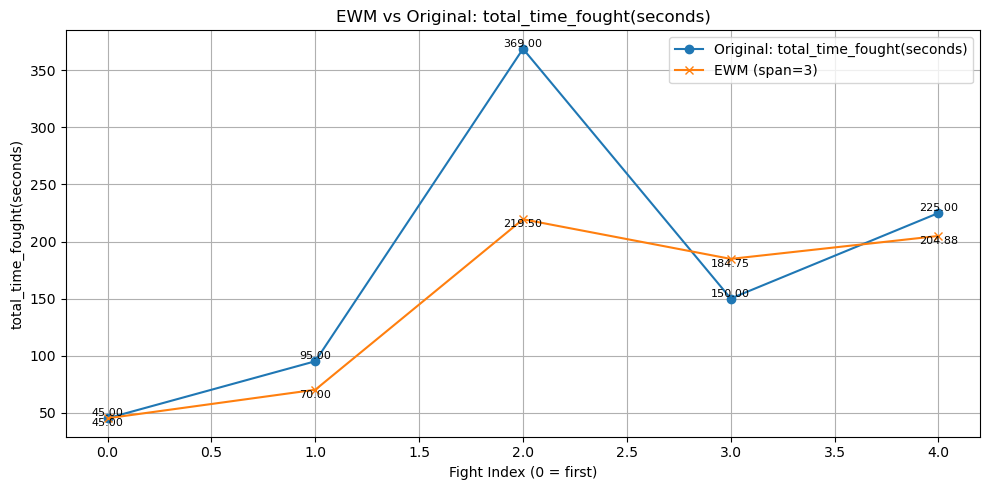

,hero_KD,opp_KD,hero_SIG_STR_pct,opp_SIG_STR_pct,hero_TD_pct,opp_TD_pct,hero_SUB_ATT,opp_SUB_ATT,hero_REV,opp_REV,...,hero_CLINCH_landed,opp_CLINCH_att,opp_CLINCH_landed,hero_GROUND_att,hero_GROUND_landed,opp_GROUND_att,opp_GROUND_landed,hero_CTRL_time(seconds),opp_CTRL_time(seconds),total_time_fought(seconds)
1653,0.3125,0.0,0.66625,0.36125,0.6875,0.0,0.625,0.0,0.0,0.0,...,2.875,0.75,0.375,11.5,8.3125,0.5,0.0,76.875,0.0,204.875


In [168]:
import matplotlib.pyplot as plt

def plot_ewm_stat(fighter_df, stat_column, span=3):
    """
    Plot original vs. EWM-smoothed stat values for a given fighter DataFrame and stat column.
    Annotates each original point with its numeric value.
    
    fighter_df should be sorted in reverse chronological order (most recent fight first).
    """
    stat_values = fighter_df[stat_column].sort_index(ascending=False)
    ewm_values = stat_values.ewm(span=span, adjust=False).mean()

    plt.figure(figsize=(10, 5))
    plt.plot(stat_values.values, label=f'Original: {stat_column}', marker='o')
    plt.plot(ewm_values.values, label=f'EWM (span={span})', marker='x')

    # Annotate each original stat value
    for i, value in enumerate(stat_values.values):
        plt.text(i, value, f'{value:.2f}', fontsize=8, ha='center', va='bottom')
    # Annotate EWM values
    for i, value in enumerate(ewm_values.values):
        plt.text(i, value, f'{value:.2f}', fontsize=8, ha='center', va='top')
    plt.gca()  # Most recent fight on the left
    plt.title(f'EWM vs Original: {stat_column}')
    plt.xlabel('Fight Index (0 = first)')
    plt.ylabel(stat_column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

TA_red = get_fighter_red('Tom Aspinall') # Make a df of all the times a fighter was red
TA_blue = get_fighter_blue('Tom Aspinall') # Same for blue

TA_fights = pd.concat([TA_red, TA_blue]).sort_index()

TA_fights[['hero_fighter', 'opp_fighter'] + Numerical_columns] # Knockdowns from oldest to newest: 1, 0, 0, 1, 0, 0, 1, 1, 1 should get higher more recently


i = 3
TA_slice = TA_fights[(i+1):].sort_index(ascending=False) # Grab every fight previous to this one.
TA_slice
plot_ewm_stat(TA_slice, 'total_time_fought(seconds)', span=3)
s = TA_slice[Numerical_columns].ewm(span=3, adjust=False).mean() # EWM gives more weighting to recent fights.
s.tail(1)

In [105]:
temp_blue_frame.T

,6043,5948,6294,3938,4522,5118,5379,724,1086,1293,...,612,819,1177,786,938,1305,1495,3075,3967,5518
hero_KD,NaN,0.0,NaN,0.25,0.0,0.0,NaN,0.5,0.0,0.0,...,0.125,0.25,0.0,0.09375,0.1875,0.75,0.5,0.0,0.0,NaN
opp_KD,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.25,0.5,0.0,0.0,0.5,0.0,NaN
hero_SIG_STR_pct,NaN,0.51,NaN,0.3575,0.42,0.0,NaN,0.4225,0.49,0.46,...,0.47875,0.5475,0.59,0.670312,0.580625,0.6125,0.605,0.45668,0.316875,NaN
opp_SIG_STR_pct,NaN,0.55,NaN,0.549375,0.2575,0.0,NaN,0.60375,0.385,0.4,...,0.45625,0.4025,0.37,0.544063,0.448125,0.4225,0.335,0.460801,0.402813,NaN
hero_TD_pct,NaN,0.0,NaN,0.205625,0.8225,1.0,NaN,0.0,0.0,0.0,...,0.375,0.75,0.0,0.125,0.25,0.0,0.0,0.039336,0.209375,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
win_by_Decision - Split,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
win_by_Decision - Unanimous,0,0,0,2,2,0,0,2,2,1,...,0,0,0,1,1,1,1,5,3,0
win_by_KO/TKO,0,0,0,0,0,0,0,1,0,0,...,2,2,1,3,3,2,1,2,2,0
win_by_Submission,0,0,0,2,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Adding fighter details like height, weight, reach, stance and dob

In [106]:
fighter_details = fighter_details[fighter_details.index.isin(fighters)] # Remove all the fighter details for fighters that haven't fought.
for col in fighter_details.columns:
    print(f"Number of NaN in {col} : {fighter_details[col].isnull().sum()}")

Number of NaN in Height : 13
Number of NaN in Weight : 10
Number of NaN in Reach : 637
Number of NaN in Stance : 63
Number of NaN in DOB : 140
Number of NaN in SLpM : 0
Number of NaN in Str_Acc : 0
Number of NaN in SApM : 0
Number of NaN in Str_Def : 0
Number of NaN in TD_Avg : 0
Number of NaN in TD_Acc : 0
Number of NaN in TD_Def : 0
Number of NaN in Sub_Avg : 0


In [107]:
def convert_to_cms(X):
    if X is np.NaN:
        return X # Do nothing with NaNs
    elif len(X.split("'")) == 2: # If the value is in format X'Y" such as for Height
        feet = float(X.split("'")[0])
        inches = int(X.split("'")[1].replace(' ', '').replace('"','')) # remove spaces and " from inches
        return (feet * 30.48) + (inches * 2.54)
    else: # This is for reach
        return float(X.replace('"','')) * 2.54

In [108]:
fighter_details['Height_cms'] = fighter_details['Height'].apply(convert_to_cms)
fighter_details['Reach_cms'] = fighter_details['Reach'].apply(convert_to_cms)

In [109]:
fighter_details['Weight_lbs'] = fighter_details['Weight'].apply(lambda X: float(X.replace(' lbs.', '')) if X is not np.NaN else X) # Move units to column title, leave numeric

In [110]:
pct_columns = ['Str_Acc','Str_Def', 'TD_Acc', 'TD_Def']

def pct_to_frac(X):
    if X != np.NaN:
        return float(X.replace('%', ''))/100
    else:
        return 0 # replacing NaNs with 0 here

for column in pct_columns:
    fighter_details[column] = fighter_details[column].apply(pct_to_frac) # Don't need to drop these columns, changing directly

In [111]:
fighter_details.drop(['Height', 'Weight', 'Reach'], axis=1, inplace=True)

In [112]:
fighter_details.reset_index(inplace=True) # Reset all the indexes to move all info into columns
temp_red_frame.reset_index(inplace=True)
temp_blue_frame.reset_index(inplace=True)

In [113]:
temp_blue_frame = temp_blue_frame.merge(fighter_details, left_on='hero_fighter', right_on='fighter_name', how='left')
temp_blue_frame.set_index('index', inplace=True)

In [182]:
mask = temp_blue_frame.columns.str.contains('hero', 'avg')
temp_blue_frame.loc[:, mask].head(20)

,hero_KD,hero_SIG_STR_pct,hero_TD_pct,hero_SUB_ATT,hero_REV,hero_SIG_STR._att,hero_SIG_STR._landed,hero_TOTAL_STR._att,hero_TOTAL_STR._landed,hero_TD_att,...,hero_LEG_att,hero_LEG_landed,hero_DISTANCE_att,hero_DISTANCE_landed,hero_CLINCH_att,hero_CLINCH_landed,hero_GROUND_att,hero_GROUND_landed,hero_CTRL_time(seconds),hero_fighter
index,,,,,,,,,,,,,,,,,,,,,
6043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mike Ricci
5948,0.00,0.5100,0.000000,0.00000,0.000,54.00,28.00000,137.00000,98.00,0.00,...,1.00000,1.0000,39.0000,16.00000,12.00000,10.00000,3.00000,2.00000,9.00,Besam Yousef
6294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Besam Yousef
3938,0.25,0.3575,0.205625,1.15625,2.375,30.25,12.84375,67.03125,44.25,1.00,...,5.21875,4.5625,23.4375,8.96875,2.34375,1.96875,4.46875,1.90625,237.00,Chris Wade
4522,0.00,0.4200,0.822500,0.62500,0.500,29.00,16.37500,70.12500,51.00,4.00,...,5.87500,5.2500,15.7500,7.87500,6.37500,4.87500,6.87500,3.62500,298.00,Chris Wade
5118,0.00,0.0000,1.000000,1.00000,0.000,1.00,0.00000,6.00000,5.00,1.00,...,0.00000,0.0000,1.0000,0.00000,0.00000,0.00000,0.00000,0.00000,44.00,Chris Wade
5379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tina Lahdemaki
724,0.50,0.4225,0.000000,0.00000,0.000,114.50,55.50000,117.00000,57.75,0.25,...,6.62500,5.5000,111.0000,52.62500,3.25000,2.87500,0.25000,0.00000,10.50,Waldo Cortes-Acosta
1086,0.00,0.4900,0.000000,0.00000,0.000,218.00,110.00000,220.00000,111.00,0.00,...,7.50000,6.0000,214.0000,107.50000,4.00000,2.50000,0.00000,0.00000,8.00,Waldo Cortes-Acosta


In [115]:
temp_red_frame = temp_red_frame.merge(fighter_details, left_on='hero_fighter', right_on='fighter_name', how='left')
temp_red_frame.set_index('index', inplace=True)

In [116]:
temp_blue_frame.drop('fighter_name', axis=1, inplace=True) # Don't need fighter_name anymore as contained in hero_fighter
temp_red_frame.drop('fighter_name', axis=1, inplace=True)

In [117]:
blue_frame = temp_blue_frame.add_prefix('B_')
red_frame = temp_red_frame.add_prefix('R_')

In [118]:
frame = blue_frame.join(red_frame, how='outer') # Recombining so all fight and fighter data is in a single row for each fight.

In [216]:
TEST_frame = blue_frame.join(red_frame, how='outer')
TEST_frame.filter(like='fighter', axis=1)

,B_hero_fighter,R_hero_fighter
index,,
0,Ludovit Klein,Mateusz Gamrot
1,Dusko Todorovic,Zachary Reese
2,Alice Ardelean,Rayanne dos Santos
3,Bruno Lopes,Dustin Jacoby
4,Macy Chiasson,Ketlen Vieira
...,...,...
8154,Robert Lucarelli,Orlando Wiet
8155,Thaddeus Luster,Frank Hamaker
8156,Ray Wizard,Patrick Smith


In [119]:
'''
Remember that opp in this case is refering to historical opponents stats against the fighter in question,
i.e. how many strikes do this fighter's opponents usually land on them?
'''
rename_cols = {}
for col in frame.columns: # Removing hero notation as it's been replaced with B_/R_ again
    if 'hero' in col:
        rename_cols[col] = col.replace('_hero_', '_avg_').replace('.', '')
    if 'opp' in col:
        rename_cols[col] = col.replace('_opp_', '_avg_opp_').replace('.', '')
    if 'win_by' in col:
        rename_cols[col] = col.replace(' ', '').replace('-', '_').replace('\'s', '_')

In [120]:
frame.rename(rename_cols, axis='columns', inplace=True)

In [121]:
frame.drop(['R_avg_fighter','B_avg_fighter'], axis=1, inplace=True)

In [122]:
df2 = df2.join(frame, how='outer')

### Create Age

In [123]:
df2['R_DOB'] = pd.to_datetime(df2['R_DOB'])
df2['B_DOB'] = pd.to_datetime(df2['B_DOB'])
df2['date'] = pd.to_datetime(df2['date'])

In [124]:
def get_age(row):
    B_age = (row['date'] - row['B_DOB']).days
    R_age = (row['date'] - row['R_DOB']).days
    if np.isnan(B_age)!=True:
        B_age = math.floor(B_age/365.25)
    if np.isnan(R_age)!=True:
        R_age = math.floor(R_age/365.25)
    return pd.Series([B_age, R_age], index=['B_age', 'R_age'])

In [125]:
df2[['B_age', 'R_age']]= df2[['date', 'R_DOB', 'B_DOB']].apply(get_age, axis=1)

In [126]:
df2.drop(['R_DOB', 'B_DOB'], axis=1, inplace=True)

In [69]:
# df2.drop(df2.index[df2['Winner'] == 'draw'], inplace = True)

In [128]:
df2.to_csv('../src/data/data.csv', index=False)

In [139]:
df2.query('date >= "2005-01-01"').isnull().sum()

R_fighter         0
B_fighter         0
Referee          25
date              0
location          0
               ... 
R_Height_cms     25
R_Reach_cms     177
R_Weight_lbs     24
B_age            38
R_age            28
Length: 161, dtype: int64

In [141]:
clean_data = df2.copy()
clean_data

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_avg_KD,...,R_Str_Def,R_TD_Avg,R_TD_Acc,R_TD_Def,R_Sub_Avg,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Mateusz Gamrot,Ludovit Klein,Herb Dean,2025-05-31,"Las Vegas, Nevada, USA",Red,False,Lightweight,3,0.642578,...,0.58,5.25,0.35,0.90,0.1,177.80,177.80,155.0,30.0,34.0
1,Zachary Reese,Dusko Todorovic,Herb Dean,2025-05-31,"Las Vegas, Nevada, USA",Red,False,Middleweight,3,0.000000,...,0.42,3.50,0.55,0.33,2.1,193.04,195.58,185.0,31.0,31.0
2,Rayanne dos Santos,Alice Ardelean,Chris Tognoni,2025-05-31,"Las Vegas, Nevada, USA",Blue,False,Women's Strawweight,3,0.000000,...,0.61,0.33,0.12,0.88,0.0,157.48,157.48,115.0,33.0,29.0
3,Dustin Jacoby,Bruno Lopes,Mike Beltran,2025-05-31,"Las Vegas, Nevada, USA",Red,False,Light Heavyweight,3,0.000000,...,0.57,0.33,0.25,0.62,0.0,190.50,193.04,205.0,32.0,37.0
4,Ketlen Vieira,Macy Chiasson,Mark Smith,2025-05-31,"Las Vegas, Nevada, USA",Red,False,Women's Featherweight,3,0.001953,...,0.51,1.39,0.44,0.88,0.6,172.72,172.72,135.0,33.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,Orlando Wiet,Robert Lucarelli,John McCarthy,1994-03-11,"Denver, Colorado, USA",Red,False,Open Weight,1,NaN,...,0.00,0.00,0.00,0.00,0.0,177.80,NaN,170.0,NaN,NaN
8155,Frank Hamaker,Thaddeus Luster,John McCarthy,1994-03-11,"Denver, Colorado, USA",Red,False,Open Weight,1,NaN,...,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN
8156,Patrick Smith,Ray Wizard,John McCarthy,1994-03-11,"Denver, Colorado, USA",Red,False,Open Weight,1,NaN,...,0.00,0.00,0.00,0.00,0.0,187.96,NaN,225.0,NaN,30.0
8157,Scott Morris,Sean Daugherty,John McCarthy,1994-03-11,"Denver, Colorado, USA",Red,False,Open Weight,1,NaN,...,0.00,0.00,0.00,0.00,0.0,177.80,NaN,210.0,18.0,NaN
